In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance
import os.path
import glob
from resizeimage import resizeimage
from sklearn import metrics

# resize images, create more images

In [2]:
def convert(jpgfile,outdir, width=64,height=64):
    img=Image.open(jpgfile)
    try:
        new_img = img.convert("RGB")
        new_img = resizeimage.resize_cover(new_img, [width, height])
        new_img = ImageEnhance.Color(new_img) 
        new_img = new_img.enhance(3)
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        new_img.save(os.path.join(outdir, os.path.basename(jpgfile)).replace('.jpg','(1).jpg'))
    except Exception as e:
        print(e)

In [3]:
def convert_mixed_class(jpgfile,outdir, width=64,height=64):
    img=Image.open(jpgfile)
    try:
        new_img = img.convert("RGB")
        new_img = resizeimage.resize_cover(new_img, [width, height])
        new_img = ImageEnhance.Color(new_img) 
        new_img = new_img.enhance(3)
        new_img2 = new_img.transpose(Image.FLIP_LEFT_RIGHT)
        new_img3 = new_img.transpose(Image.FLIP_TOP_BOTTOM)
        new_img4 = new_img.transpose(Image.ROTATE_90)

        if not os.path.exists(outdir):
            os.mkdir(outdir)
        new_img.save(os.path.join(outdir, os.path.basename(jpgfile)).replace('.jpg','(1).jpg'))
        new_img2.save(os.path.join(outdir, os.path.basename(jpgfile)).replace('.jpg','(2).jpg'))
        new_img3.save(os.path.join(outdir, os.path.basename(jpgfile)).replace('.jpg','(3).jpg'))
        new_img4.save(os.path.join(outdir, os.path.basename(jpgfile)).replace('.jpg','(4).jpg'))

    except Exception as e:
        print(e)

In [6]:
for jpgfile in glob.glob("images\\train\\*.jpg"):
    convert(jpgfile,"images\\train_resize\\")
for jpgfile in glob.glob("images\\test\\*.jpg"):
    convert(jpgfile,"images\\test_resize\\")

In [7]:
for jpgfile in glob.glob("images\\train\\mixed_*.jpg"):
    convert_mixed_class(jpgfile,"images\\train_resize\\")

# processing images into data and label

In [8]:
def processing_image(RGB_file):
    im=Image.open(RGB_file)
    im_data=[[im.getpixel((y,x)) for y in range(im.size[1])] for x in range(im.size[0])]
    return im_data

In [9]:
X_train=np.array([processing_image(image) for image in glob.glob("images\\train_resize\\*.jpg")])/255
X_test=np.array([processing_image(image) for image in glob.glob("images\\test_resize\\*.jpg")])/255
y_train=np.array([image.split('_')[0] for image in os.listdir("images\\train_resize\\")])
y_test=np.array([image.split('_')[0] for image in os.listdir("images\\test_resize\\")])

In [10]:
# label the classes with int
le=LabelEncoder()
le=le.fit(y_train)
y_train=le.transform(y_train)
y_test=le.transform(y_test)
# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

(296, 64, 64, 3)
(296, 4)
(60, 64, 64, 3)
(60, 4)
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


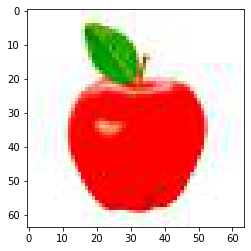

In [11]:
#show the scale of the training set, test set and a sample image
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
plt.imshow(X_train[8])
print(X_train[8])

# build cnn model

In [12]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=(64, 64, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))        
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'))        
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding = 'same', activation='relu'))        
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())    
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

# train the cnn model

In [13]:
history=model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1,validation_data=(X_test, y_test),shuffle=True)
score = model.evaluate(X_test, y_test)
print("score =", score)

Epoch 1/50
5/5 [==============================] - 2s 244ms/step - loss: 1.4026 - accuracy: 0.2432 - val_loss: 1.3669 - val_accuracy: 0.3500
Epoch 2/50
5/5 [==============================] - 1s 190ms/step - loss: 1.3883 - accuracy: 0.2399 - val_loss: 1.3634 - val_accuracy: 0.4167
Epoch 3/50
5/5 [==============================] - 1s 220ms/step - loss: 1.3609 - accuracy: 0.3986 - val_loss: 1.3170 - val_accuracy: 0.3167
Epoch 4/50
5/5 [==============================] - 1s 193ms/step - loss: 1.1908 - accuracy: 0.5405 - val_loss: 0.8882 - val_accuracy: 0.6000
Epoch 5/50
5/5 [==============================] - 1s 213ms/step - loss: 1.1235 - accuracy: 0.5068 - val_loss: 0.8431 - val_accuracy: 0.6667
Epoch 6/50
5/5 [==============================] - 1s 209ms/step - loss: 0.9752 - accuracy: 0.5743 - val_loss: 0.8215 - val_accuracy: 0.7667
Epoch 7/50
5/5 [==============================] - 1s 207ms/step - loss: 0.8892 - accuracy: 0.6385 - val_loss: 0.7920 - val_accuracy: 0.6333
Epoch 8/50
5/5 [====

In [14]:
predict = model.predict(X_test)
for i in np.arange(len(predict)):
    print('Actual: ', np.argmax(y_test[i]), 'Predicted: ', np.argmax(predict[i]))

Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  0 Predicted:  0
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  2
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  3
Actual:  1 Predicted:  1
Actual:  1 Predicted:  0
Actual:  1 Predicted:  2
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  1 Predicted:  1
Actual:  2 Predicted:  3
Actual:  2 Predicted:  2
Actual:  2 Predicted:  2


In [15]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix (np.argmax(y_test, axis=1), np.argmax(predict, axis=1))

D:\ProgramData\Anaconda3\envs\pythonEx\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['apple', 'banana', 'mixed', 'orange'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


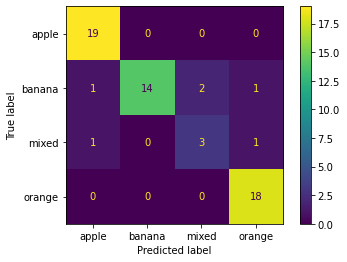

In [16]:
metrics.ConfusionMatrixDisplay(cm, ['apple','banana','mixed','orange']).plot()

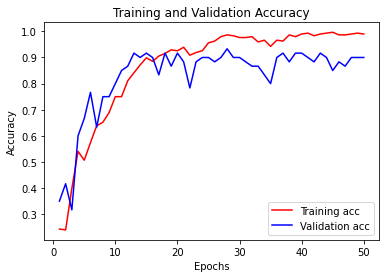

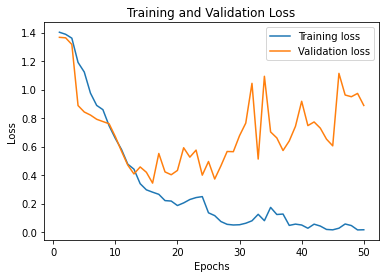

In [17]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'r', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, history.history['loss'], label='Training loss')
plt.plot(epochs, history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()